In [1]:
from cnns_classes import t1_quantizedCNN, t2_quantizedCNN
from utils import utils

In [2]:
#https://www.kaggle.com/code/vmarkin/advatt
# carregar as bibliotecas básicas necessárias
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from utils import utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

# gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline
torch.manual_seed(4)

In [3]:
batch_size = 512

train_dataset_output_name = "train_dataset.pkl"
test_dataset_output_name = "test_dataset.pkl"

topologies = [
    {
        'id':1, 
        'tp_class':t1_quantizedCNN,
        'quant': [2,4,8]
    },
    {
        'id':2, 
        'tp_class':t2_quantizedCNN,
        'quant': [2,4,8]
    }
]

target_fps_list = [500,5000,50000]

device = torch.device('cpu')

In [4]:
class SatImgDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = T.ToTensor()
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.transform(self.X[index])
        y = torch.FloatTensor(self.y[index])
        return {'x':x, 'y':y}

In [5]:
dataset_test = utils.read_object(test_dataset_output_name)
loader_test = DataLoader(dataset_test, batch_size, shuffle=False)

In [6]:
def test_model(topology,topology_class,model_filename,quant):
    print(f"testing t{topology}w{quant}")
    model = topology_class(bit_quantization=quant)
    model.load_state_dict(torch.load(model_filename))
    with torch.no_grad():
        correct = 0
        i=0
        for batch in loader_test:
            pred = model(batch['x'].to(device))
            predicted = torch.max(pred, 1)[1]
            real_class = torch.max(batch['y'].to(device), 1)[1]
            correct += (predicted == real_class).sum()    
    accuracy = correct.item()/len(dataset_test)*100
    print(f"accuracy of this model: {accuracy}% ({len(dataset_test)} test cases)")
    print(f"finishing testing")
    return accuracy

In [7]:
def getNOutputs(n,topology,topology_class,model_filename,quant):
    print(f"executing t{topology}w{quant} for {n} inputs")
    model = topology_class(bit_quantization=quant)
    model.load_state_dict(torch.load(model_filename))
    outputs = []
    with torch.no_grad():
        correct = 0
        i=0
        for batch in loader_test:
            pred = model(batch['x'].to(device))
            predicted = torch.max(pred, 1)[1]   
            outputs.extend(predicted.numpy())
    return outputs[:1000]    

In [8]:
real_outputs = []
for i in range(1000):
    real_outputs.append(np.argmax(dataset_test[i]['y'].numpy(), axis=0))

print(real_outputs)

[2, 2, 5, 1, 5, 2, 5, 1, 5, 5, 5, 2, 2, 5, 2, 3, 1, 5, 0, 0, 3, 3, 1, 5, 1, 0, 5, 1, 3, 1, 5, 5, 5, 5, 0, 1, 5, 1, 3, 2, 2, 5, 2, 3, 2, 5, 4, 2, 5, 1, 2, 1, 2, 3, 2, 2, 2, 3, 5, 5, 1, 5, 3, 5, 4, 2, 1, 1, 5, 5, 2, 3, 5, 5, 1, 1, 5, 5, 3, 5, 5, 2, 5, 1, 1, 3, 2, 5, 3, 2, 2, 1, 1, 2, 2, 2, 1, 1, 4, 3, 5, 5, 0, 5, 1, 3, 0, 1, 5, 3, 5, 1, 1, 5, 3, 1, 5, 1, 1, 2, 3, 5, 3, 1, 5, 5, 2, 1, 2, 5, 2, 3, 5, 2, 3, 1, 2, 5, 5, 2, 3, 1, 1, 2, 5, 2, 2, 2, 2, 1, 1, 5, 4, 1, 1, 1, 2, 1, 2, 5, 5, 1, 5, 5, 3, 5, 1, 2, 5, 3, 5, 0, 2, 2, 1, 5, 5, 1, 5, 1, 5, 1, 1, 5, 2, 1, 3, 0, 5, 5, 5, 2, 5, 3, 2, 2, 3, 1, 1, 5, 3, 3, 1, 2, 1, 1, 5, 3, 1, 5, 5, 1, 1, 1, 1, 3, 3, 5, 5, 1, 3, 2, 2, 1, 2, 3, 1, 1, 3, 2, 5, 2, 1, 3, 2, 5, 1, 3, 3, 3, 5, 0, 5, 1, 5, 1, 5, 2, 1, 1, 5, 5, 5, 2, 2, 1, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 3, 2, 2, 2, 5, 5, 2, 1, 5, 2, 5, 1, 1, 2, 5, 5, 1, 2, 3, 4, 5, 3, 3, 3, 3, 1, 5, 1, 5, 1, 0, 5, 5, 2, 1, 1, 5, 5, 2, 5, 1, 3, 2, 5, 5, 1, 5, 3, 4, 5, 1, 1, 5, 2, 3, 3, 1, 2, 4, 5, 2, 5, 2, 4, 4, 5, 

In [9]:
import numpy
import os
import re

def get_hardware_outputs(topology,quant,target_fps):
    caminho_da_pasta = f"/home/artti/Desktop/finn/notebooks/sat6_cnn/builds/build_t{topology}w{quant}_{target_fps}fps/verification_output/"
    
    arquivos_na_pasta = os.listdir(caminho_da_pasta)
    
    array_outputs = numpy.zeros(len(arquivos_na_pasta))
    
    # Itera sobre cada arquivo
    for nome_arquivo in arquivos_na_pasta:
        caminho_arquivo = os.path.join(caminho_da_pasta, nome_arquivo)
        output = numpy.load(caminho_arquivo)
        padrao = re.compile(r"_([0-9]+)_")
        correspondencia = padrao.search(nome_arquivo)    
        numero_do_teste = int(correspondencia.group(1))
        array_outputs[numero_do_teste] = output[0]
    
    return array_outputs

In [10]:
def arraysCorrectness(a,b):
    if(len(a) == len(b)):
        sucess = 0
        for i in range(len(a)):
            if (int(a[i]) == b[i]):
                sucess = sucess + 1            
    
        correctness = sucess/len(a)
        return correctness

In [12]:
#checking if the outputs are the same...they are!!!
for tp in topologies:
    for quant in tp['quant']:
        hardware_config_name = f"t{tp['id']}w{quant}"
        ! diff -s ./pynq_results/runs/{hardware_config_name}/hardware_output_{hardware_config_name}_500fps.npy ./pynq_results/runs/{hardware_config_name}/hardware_output_{hardware_config_name}_5000fps.npy
        ! diff -s ./pynq_results/runs/{hardware_config_name}/hardware_output_{hardware_config_name}_500fps.npy ./pynq_results/runs/{hardware_config_name}/hardware_output_{hardware_config_name}_50000fps.npy

Files ./pynq_results/runs/t1w2/hardware_output_t1w2_500fps.npy and ./pynq_results/runs/t1w2/hardware_output_t1w2_5000fps.npy are identical
Files ./pynq_results/runs/t1w2/hardware_output_t1w2_500fps.npy and ./pynq_results/runs/t1w2/hardware_output_t1w2_50000fps.npy are identical
Files ./pynq_results/runs/t1w4/hardware_output_t1w4_500fps.npy and ./pynq_results/runs/t1w4/hardware_output_t1w4_5000fps.npy are identical
Files ./pynq_results/runs/t1w4/hardware_output_t1w4_500fps.npy and ./pynq_results/runs/t1w4/hardware_output_t1w4_50000fps.npy are identical
Files ./pynq_results/runs/t1w8/hardware_output_t1w8_500fps.npy and ./pynq_results/runs/t1w8/hardware_output_t1w8_5000fps.npy are identical
Files ./pynq_results/runs/t1w8/hardware_output_t1w8_500fps.npy and ./pynq_results/runs/t1w8/hardware_output_t1w8_50000fps.npy are identical
Files ./pynq_results/runs/t2w2/hardware_output_t2w2_500fps.npy and ./pynq_results/runs/t2w2/hardware_output_t2w2_5000fps.npy are identical
Files ./pynq_results/run

testing t1w2
accuracy of this model: 4.5851851851851855% (81000 test cases)
finishing testing
executing t1w2 for 1000 inputs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



testing t1w4
accuracy of this model: 86.68148148148148% (81000 test cases)
finishing testing
executing t1w4 for 1000 inputs

testing t1w8
accuracy of this model: 98.58148148148148% (81000 test cases)
finishing testing
executing t1w8 for 1000 inputs

testing t2w2
accuracy of this model: 89.18518518518519% (81000 test cases)
finishing testing
executing t2w2 for 1000 inputs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



testing t2w4
accuracy of this model: 96.69876543209877% (81000 test cases)
finishing testing
executing t2w4 for 1000 inputs

testing t2w8
accuracy of this model: 98.79506172839505% (81000 test cases)
finishing testing
executing t2w8 for 1000 inputs



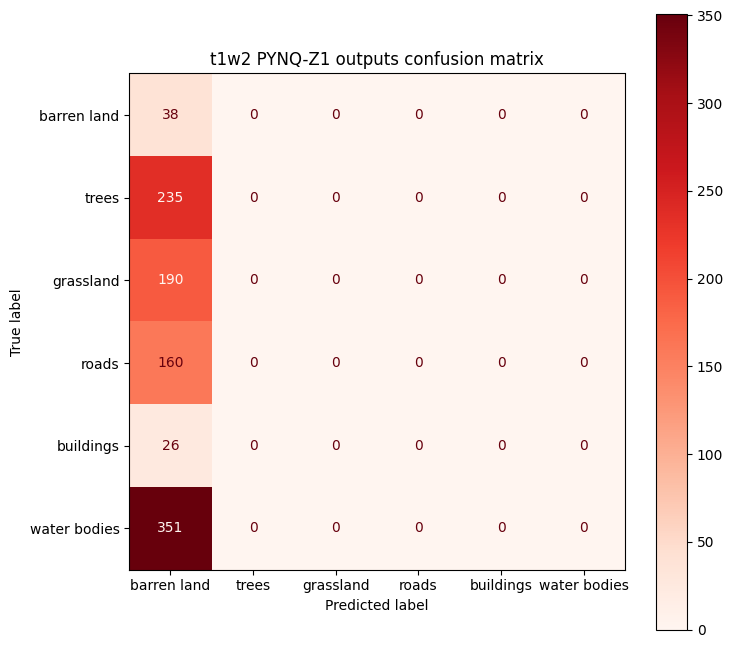

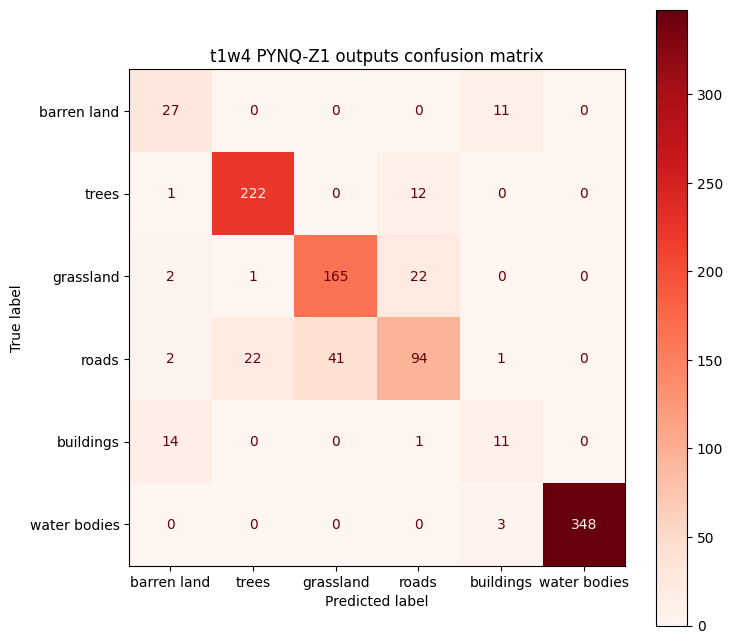

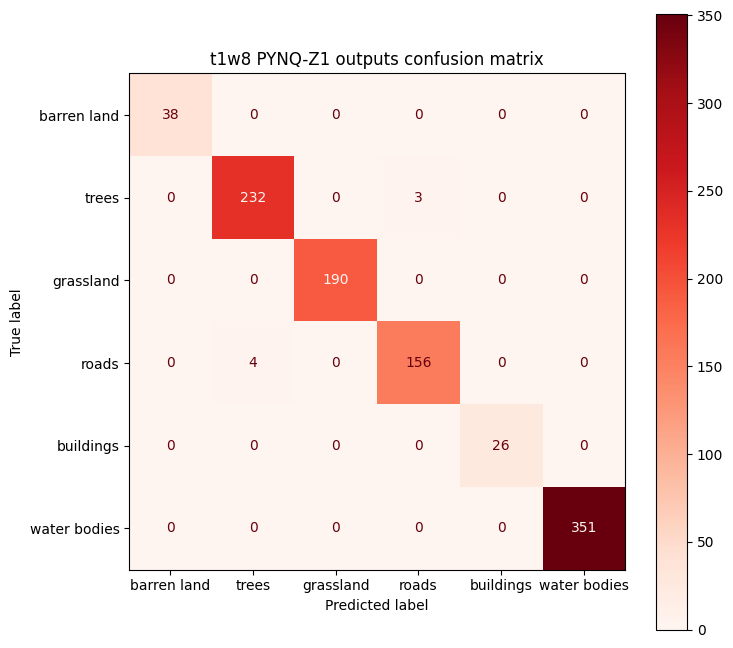

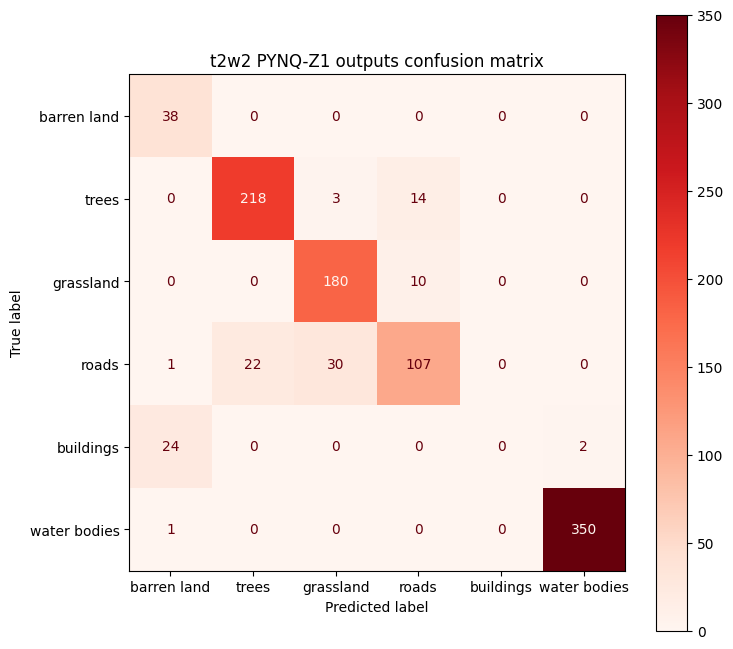

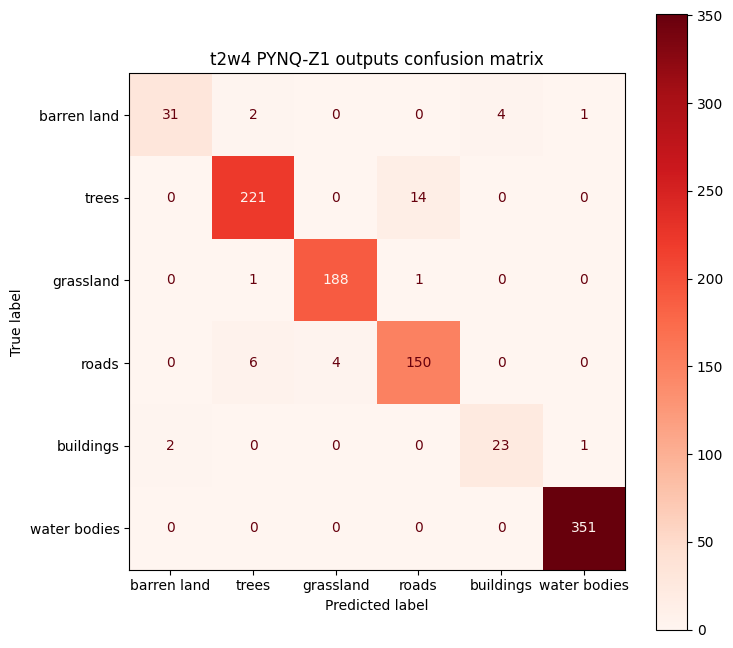

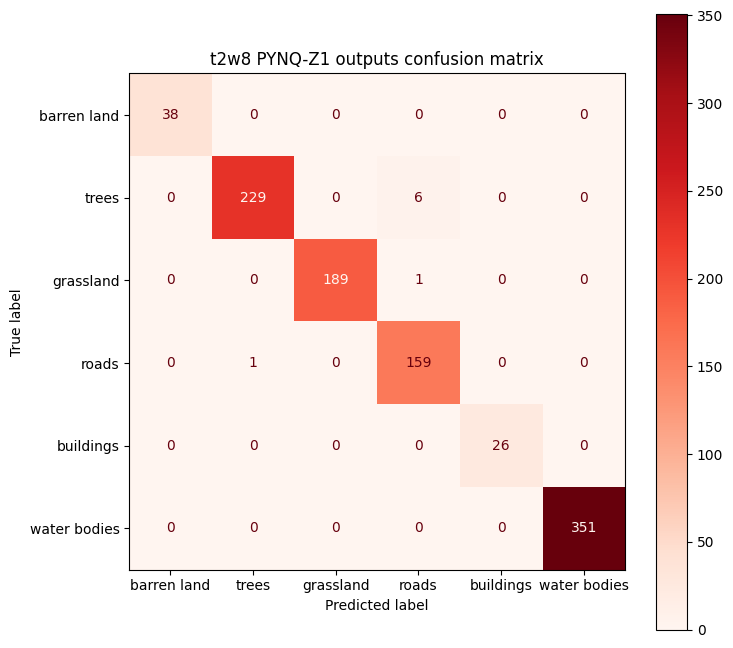

In [19]:
# headers = [
#     'Hardware (HW) config',
#     'Pytorch Model (PM) precise accuracy (81000)',
#     'PM accuracy (1000)','HW simulation accuracy (1000)',
#     'PM precision (1000)','HW simulation precision (1000)',
#     'PM recall (1000)','HW simulation recall (1000)',
#     'HW simulation and PM correspondence (1000)'
# ]

headers = [
    'Hardware (HW) config',
    'Pytorch Model (PM) precise accuracy (81000)',
    'HW simulation accuracy (1000)',
    'HW simulation precision (1000)',
    'HW simulation recall (1000)',
    'HW simulation and PM correspondence (1000)'
]
cofiability_data = [headers]

for tp in topologies:
    for quant in tp['quant']:
            pm_precise_accuracy = test_model(topology=tp['id'],topology_class=tp['tp_class'], model_filename=utils.get_model_output_filename(topology=tp['id'],quant=quant), quant=quant)
            pm_precise_accuracy = round(pm_precise_accuracy, 2)
            software_outputs = getNOutputs(n=1000, topology=tp['id'],topology_class=tp['tp_class'], model_filename=utils.get_model_output_filename(topology=tp['id'],quant=quant), quant=quant)
            # for target_fps in target_fps_list:
            target_fps = 1000 #all of them are going to be the same
            hardware_config_name = f"t{tp['id']}w{quant}"
            hardware_sim_outputs = np.load(f"./pynq_results/runs/{hardware_config_name}/hardware_output_{hardware_config_name}_500fps.npy")
            
            #confusion matrix for PM
            pm_accuracy= accuracy_score(software_outputs, real_outputs)
            pm_precision, pm_recall, pm_fscore, pm_support = score(software_outputs, real_outputs)
            # pm_cm = confusion_matrix(software_outputs, real_outputs)
            # fig, ax = plt.subplots(figsize=(8,8))
            # disp = ConfusionMatrixDisplay.from_predictions(
            #     y_pred=software_outputs,
            #     y_true=real_outputs,
            #     labels=[0,1,2,3,4,5],
            #     display_labels=['barren land', 'trees', 'grassland', 'roads', 'buildings', 'water bodies'],
            #     ax=ax,
            #     cmap='Reds',
            # )
            # disp.ax_.set_title(f"{hardware_config_name} software simulation confusion matrix")
            # plt.savefig(f'./results/confusion_matrices/t{tp['id']}w{quant}_confusion_matrix.png')   
            
            #confusion matrix for HW
            hw_accuracy = accuracy_score(hardware_sim_outputs, real_outputs)
            hw_precision, hw_recall, hw_fscore, hw_support = score(hardware_sim_outputs, real_outputs)                                             
            fig, ax = plt.subplots(figsize=(8,8))
            disp = ConfusionMatrixDisplay.from_predictions(
                y_pred=hardware_sim_outputs,
                y_true=real_outputs,
                labels=[0,1,2,3,4,5],
                display_labels=['buildings','barren land', 'trees', 'grassland', 'roads', 'water bodies'],
                ax=ax,
                cmap='Reds',
            )
            disp.ax_.set_title(f"{hardware_config_name} PYNQ-Z1 outputs confusion matrix")
            plt.savefig(f'./pynq_results/confusion_matrices/{hardware_config_name}_hw_confusion_matrix.png')  
            # plt.savefig(f'./results/confusion_matrices/{hardware_config_name}_hw_confusion_matrix.png')   

            correctness = accuracy_score(software_outputs, hardware_sim_outputs)
            
            cofiability_data.append([
                hardware_config_name, 
                pm_precise_accuracy, 
                (hw_accuracy*100), 
                hw_precision,
                hw_recall,
                (correctness*100)
            ])
            print("")

In [20]:
utils.save_csv_table(results=cofiability_data, csv_pathname="./results/confiability_results.csv")

Hardware (HW) config Pytorch Model (PM) precise accuracy (81000) HW simulation accuracy (1000)                                                                              HW simulation precision (1000)                                                                                              HW simulation recall (1000) HW simulation and PM correspondence (1000)
                t1w2                                        4.59                           3.8                                                                              [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                         [0.038, 0.0, 0.0, 0.0, 0.0, 0.0]                                      100.0
                t1w4                                       86.68                          86.7 [0.7105263157894737, 0.9446808510638298, 0.868421052631579, 0.5875, 0.4230769230769231, 0.9914529914529915]                [0.5869565217391305, 0.9061224489795918, 0.80097

In [13]:
#TODO: PYNQ outputs